<a href="https://colab.research.google.com/github/jonatanbarkan/ACEDeep/blob/master/ADCEs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [153]:
import numpy as np
from scipy.spatial.transform import Rotation
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, TensorDataset
import tqdm
import pandas as pd
import matplotlib as mpl
from collections import defaultdict
from time import sleep

sns.set_style("whitegrid")
# mpl.rcParams['figure.figsize'] = [12., 8.0]


In [154]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


### Create Samples

In [155]:
d = 3
num_samples = 10000

In [156]:
mu = [0]*d
cov = np.eye(d)

In [157]:
kind = 'hex'
# kind = 'scatter'

In [158]:
Z = np.random.multivariate_normal(mu, cov, num_samples)
N1 = np.random.multivariate_normal(mu,  cov, num_samples)
N2 = np.random.multivariate_normal(mu,  cov, num_samples)

In [159]:
X_prior = Z + np.array([.5, .1, 1.2]) * N1
Y_prior = Z + np.array([.5, .1, 1.2]) * N2

In [160]:
# (np.array([.5, .1, 1.2]) * N1).shape

In [161]:
def draw_correlations(A, B, prnt=True, plot=False, **kwargs):
  eziz = []
  for i in range(A.shape[-1]):
    corr = np.corrcoef(A[:,i], B[:,i])[0,1]
    eziz.append(corr)
    if prnt:
      print(f'correlations {i}th entry: {corr}')
    if plot:
       p = sns.jointplot(A[:, i], B[:, i], kind=kind)
       p.set_axis_labels(*[f'{l}_{i}' for l in kwargs.get('labels', ["A", "B"])])
       p.fig.suptitle(kwargs.get('title', '') + f'\ncorrelation = {corr}')
       #  p.ax_joint.collections[0].set_alpha(0)
       p.fig.tight_layout()
       p.fig.subplots_adjust(top=0.90) # Reduce plot to make room 
  sleep(0.1)
  return eziz

In [162]:
# dx = {f'x{i}': X_prior[:, i] for i in range(X_prior.shape[-1])}
# dy = {f'y{i}': Y_prior[:, i] for i in range(Y_prior.shape[-1])}
# sns.pairplot(pd.DataFrame({**dx, **dy}))

correlations 0th entry: 0.7996572594718444
correlations 1th entry: 0.9899865237311534
correlations 2th entry: 0.4135256020560803


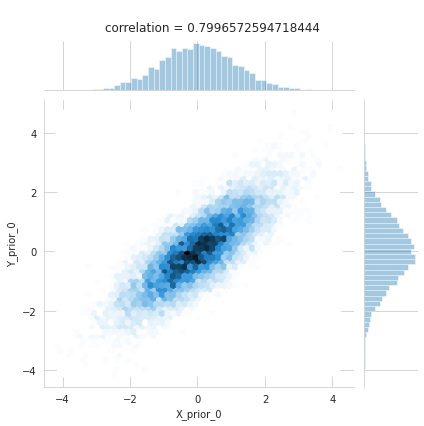

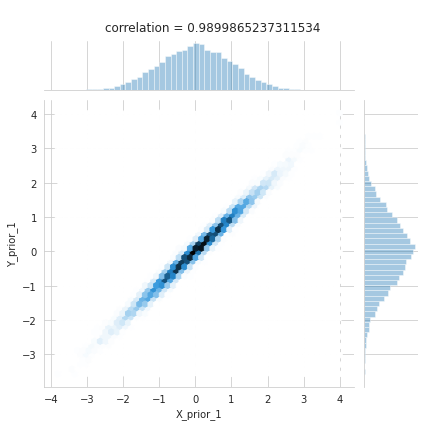

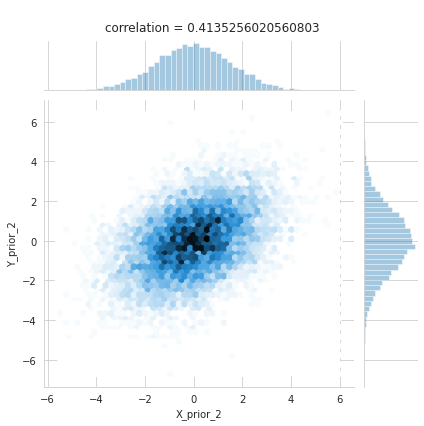

In [163]:
t = draw_correlations(X_prior, Y_prior, plot=True, labels=['X_prior', 'Y_prior'])

In [164]:
add_non_linearity = True

In [165]:
def non_linearity_a(vec): return np.array([np.exp(vec[0]), vec[2], vec[1] + vec[2] ** 3])

In [208]:
non_linearity_1 = lambda a: a
non_linearity_2 = lambda a: a
if add_non_linearity:
  non_linearity_1 = lambda a: np.exp(a) + a[1]
  non_linearity_2 = lambda a: 1/a + a[1]
  # non_linearity_1 = non_linearity_a

In [209]:
non_linearity_a(np.array([5, 6, 7]))

array([148.4131591,   7.       , 349.       ])

In [210]:
X_non_linear = non_linearity_1(X_prior)
Y_non_linear = non_linearity_2(Y_prior)

In [211]:
Y_non_linear.shape

(10000, 3)

In [212]:
thetaX = [0] * d
thetaX[2] = np.pi/3
rot_axis_X = np.array([1, 1, 1])
rotX = Rotation.from_rotvec(thetaX * rot_axis_X)
X = rotX.apply(X_non_linear)

In [213]:
print(f'X: mean {np.mean(X, axis=0)}, std {np.std(X, axis=0)}')

X: mean [-1.38141576  2.08724481  3.97224412], std [ 2.38001254  2.71867917 10.18202066]


In [214]:
thetaY = [0] * d
thetaY[0] = -np.pi / 2
thetaY[1] = -np.pi / 6
rot_axis_Y = np.array([1, 1, 1])
rotY = Rotation.from_rotvec(thetaY * rot_axis_Y)
Y = rotY.apply(Y_non_linear)

In [215]:
print(f'X: mean {np.mean(Y, axis=0)}, std {np.std(Y, axis=0)}')

X: mean [ 1.43916513  4.19660404 -9.01438072], std [ 368.1836206   149.56359551 1055.38840873]


$X, Y$ are rotations of a linear combination of $Z + \lambda N1$ and $Z + \lambda N2$ respectively, where $Z, N1, N2$ each drawn from a multivariate gaussian with 0 mean and unit covariance.
$\lambda=0.1$ and the rotations are different and are performed around different axes.

In [216]:
draw_correlations(X,Y)

correlations 0th entry: -0.00027771121459421196
correlations 1th entry: -0.0030418063777908066
correlations 2th entry: 0.0022654175879764354


[-0.00027771121459421196, -0.0030418063777908066, 0.0022654175879764354]

### create pytorch model class

notice there is no normalization at the final output. Normalization is performed with apply_transform function

In [217]:
class Model(nn.Module):
  def __init__(self, hidden_size, input_size, output_size, lr=0.01, activation=None):
      super(Model, self).__init__()
      self.fc1 = nn.Linear(input_size, hidden_size)
      # nn.init.xavier_normal_(self.fc1.weight)
      self.bn1 = nn.BatchNorm1d(num_features=hidden_size)
      self.fc2 = nn.Linear(hidden_size, output_size)
      # nn.init.xavier_normal_(self.fc2.weight)
      self.bn2 = nn.BatchNorm1d(num_features=output_size, )
      
      self.learning_rate = lr
      self._criterion = nn.MSELoss()
      self._optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
      self.activation = activation
      
  def forward(self, x):
      u = self.fc1(x)
      u = self.bn1(u)
      if self.activation is not None:
        u = self.activation(u)
      u = self.fc2(u)
      u = self.bn2(u)
      return u
    
  def get_criterion(self):
      return self._criterion

  def get_optimizer(self):
      return self._optimizer
  

In [218]:
class MlpNet(nn.Module):
    def __init__(self, layer_sizes, input_size, lr=0.01, activation=None):
        super(MlpNet, self).__init__()
        if activation is None:
          activation = nn.Identity()
        layers = []
        layer_sizes = [input_size] + layer_sizes
        for l_id in range(len(layer_sizes) - 1):
            if l_id == len(layer_sizes) - 2:
                layers.append(nn.Sequential(
                    nn.BatchNorm1d(num_features=layer_sizes[l_id], affine=False),
                    nn.Linear(layer_sizes[l_id], layer_sizes[l_id + 1]),
                ))
            else:
                layers.append(nn.Sequential(
                    nn.Linear(layer_sizes[l_id], layer_sizes[l_id + 1]),
                    activation(),
                    nn.BatchNorm1d(num_features=layer_sizes[l_id + 1], affine=False),
                ))
        
        self.layers = nn.ModuleList(layers)
        self.learning_rate = lr
        self._criterion = nn.MSELoss()
        self._optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def get_criterion(self):
        return self._criterion

    def get_optimizer(self):
        return self._optimizer

In [219]:
def make_train_step(model):
    # Builds function that performs a step in the train loop
    loss_fn = model.get_criterion()
    optimizer = model.get_optimizer()
    def train_step(x, y):
        # Sets model to TRAIN mode
        model.train()
        # Makes predictions
        yhat = model(x)
        # Computes loss
        loss = loss_fn(y.detach(), yhat)
        # Computes gradients
        loss.backward()
        # Updates parameters and zeroes gradients
        optimizer.step()
        optimizer.zero_grad()
        # Returns the loss
        return loss.item()
    
    # Returns the function that will be called inside the train loop
    return train_step

In [220]:
def make_eval_step(model):
    # Builds function that performs a step in the train loop
    loss_fn = model.get_criterion()
    def eval_step(x, y):
        # Sets model to TRAIN mode
        model.eval()
        # Makes predictions
        yhat = model(x)
        # Computes loss
        loss = loss_fn(y, yhat)
        return loss.item()
    
    # Returns the function that will be called inside the train loop
    return eval_step

### train and eval functions

In [221]:
def find_orthogonal(M, vec):
  # M an orthogonal matrix, vec the starting vector to be orthogonalized wrt M
  # using (modified?) gram schmidt while assuming M is already orthogonal
  def projection(u, v):
      return ((v * u).sum() / (u * u).sum()) * u
  vec -= torch.sum(torch.cat([projection(M[i, :], vec) for i in range(M.shape[0])], dim=1))
  return vec 

In [222]:
def apply_initial_guess(inp, method='model', **kwargs):
  if method == 'model':
    return inp
  if method == 'independent':
    pass
  if method == 'mean':
    return (inp.mean() * torch.ones([inp.shape[0], 1])).detach()
  if method == 'zero':
    return torch.zeros([inp.shape[0], 1])
  
  raise NotImplementedError(f'initialization method {method} not implemented')

In [223]:
def apply_transform(model, inp, first=False, **kwargs):
  model.eval()
  out = model(inp)
  if first:
    out = apply_initial_guess(out, model=model, **kwargs)
  out -= out.mean(axis=0)
  std = out.std(axis=0)
  if not first:
    out = torch.div(out, out.std(axis=0))
  return out

In [224]:
def learn(loader, _x_model, _y_model, _x_train_step, _y_train_step, _max_samples=np.inf, first=False):
  U = []
  V = []
  losses_x = []
  losses_y = []

  sample_count = 0
  for x_batch, y_batch in loader:
    sample_count += len(x_batch)
    if sample_count > _max_samples:
      break
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)

    transformed_y_batch = apply_transform(_y_model, y_batch, first)
    if first:
      first = False
    loss_x = _x_train_step(x_batch, transformed_y_batch)
    losses_x.append(loss_x)

    transformed_x_batch = apply_transform(_x_model, x_batch)
    loss_y = _y_train_step(y_batch, transformed_x_batch)
    losses_y.append(loss_y)

    U.append(apply_transform(_y_model, y_batch))
    V.append(transformed_y_batch)
  U = torch.cat(U)
  V = torch.cat(V)
  # UV = U * V
  # corr = UV.mean(axis=0).item()
  corr = draw_correlations(U.detach().numpy(), V.detach().numpy(), False, False)[0]

  return corr, np.mean(losses_x), np.mean(losses_y)


In [225]:
def evaluate(loader, _x_model, _y_model, _x_eval_step, _y_eval_step, first=False):
  X = []
  Y = []
  U = []
  V = []
  val_loss_x = []
  val_loss_y = []
  with torch.no_grad(): 
    for x_val, y_val in loader:
      x_val = x_val.to(device)
      y_val = y_val.to(device)

      transformed_y_batch = apply_transform(_y_model, y_val, first)
      transformed_x_batch = apply_transform(_x_model, x_val, first)

      X.append(x_val)
      Y.append(y_val)
      U.append(transformed_x_batch)
      V.append(transformed_y_batch)

      val_loss_x.append(_x_eval_step(x_val, transformed_y_batch))
      val_loss_y.append(_y_eval_step(y_val, transformed_x_batch))
  X = torch.cat(X)
  Y = torch.cat(Y)
  U = torch.cat(U)
  V = torch.cat(V)
  # UV = U * V
  # return (U, V), np.mean(val_loss_x), np.mean(val_loss_y)
  # corr = UV.mean(axis=0).item()
  corr = draw_correlations(U, V, False, False)[0]
  return corr, (X, Y, U, V), np.mean(val_loss_x), np.mean(val_loss_y)


In [226]:
def build_models(cls, *args):
  model1 = cls(*args)
  model2 = cls(*args)

  train_step1 = make_train_step(model1)
  train_step2 = make_train_step(model2)

  eval_step1 = make_eval_step(model1)
  eval_step2 = make_eval_step(model2)
  return model1, model2, train_step1, train_step2, eval_step1, eval_step2


### create data split

In [227]:
x_tensor = torch.from_numpy(X).float()
y_tensor = torch.from_numpy(Y).float()
z_tensor = torch.from_numpy(Z).float()

In [228]:
from sklearn.model_selection import train_test_split

In [229]:
X_train, X_test, Y_train, Y_test, Z_train, Z_test = train_test_split(x_tensor, y_tensor, z_tensor, test_size=0.3, random_state=42, shuffle=False)

In [230]:
train_dataset = TensorDataset(X_train, Y_train)
val_dataset = TensorDataset(X_test, Y_test)

In [231]:
# train_dataset, val_dataset = random_split(dataset, [train_len, val_len])

### Run

In [232]:
max_samples = len(train_dataset) // 1

In [233]:
max_samples

7000

In [234]:
wanted_dim = 1

In [235]:
hidden_size = 8
max_epochs = 15
lr = 0.01
act = None
# act = F.softsign
# act = torch.sin
act = F.relu
act = nn.ReLU
act = nn.Sigmoid
# batch_size = len(train_dataset) // 100
batch_size = 32

In [236]:
print(batch_size)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size)

32


In [237]:
# x_model, y_model, x_train_step, y_train_step, x_eval_step, y_eval_step = \
#   build_models(Model, hidden_size, X.shape[-1], wanted_dim, lr, act)

In [238]:
# layer_sizes, input_size, output_size, lr=0.01, activation=None
layer_sizes = [1024, 1024, 1024, wanted_dim]
layer_sizes = [hidden_size, hidden_size, hidden_size, wanted_dim]
x_model, y_model, x_train_step, y_train_step, x_eval_step, y_eval_step = \
  build_models(MlpNet, layer_sizes, X.shape[-1], lr, act)


epoch: -1	score(correlation) 0.128	X model loss 0.299	Y model loss 0.248


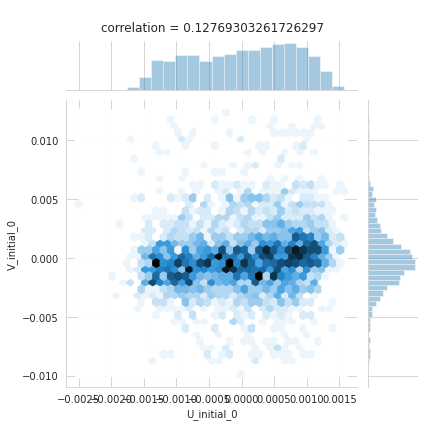

In [239]:
first = True

last_score, (_, _, Us, Vs) , val_x_loss, val_y_loss = evaluate(val_loader, x_model, y_model, x_eval_step, y_eval_step, first=first)
draw_correlations(Us, Vs, False, True, labels=['U_initial', 'V_initial'])
training_first_score, (_, _, Us, Vs) , train_x_loss, train_y_loss = evaluate(train_loader, x_model, y_model, x_eval_step, y_eval_step, first=first)

s = f'epoch: {-1}\tscore(correlation) {last_score:.3}\tX model loss {val_x_loss:.3}\tY model loss {val_y_loss:.3}'
print(s)

In [240]:
scores = defaultdict(list)
losses = defaultdict(list)

# scores['validation'].append(last_score)
# # scores['training'].append(training_first_score)
# scores['epoch'].append(-1)

# losses['x_model_validation'].append(val_x_loss)
# losses['y_model_validation'].append(val_y_loss)
# losses['x_model_training'].append(train_x_loss)
# losses['y_model_training'].append(train_y_loss)
# losses['epoch'].append(-1)

for epoch in range(max_epochs):
  # train
  train_score, train_x_loss, train_y_loss = learn(train_loader, x_model, y_model, x_train_step, y_train_step, _max_samples=max_samples, first=first)
  if first:
    first = False
  # validate
  current_score, (Xs, Ys, Us, Vs), val_x_loss, val_y_loss = evaluate(val_loader, x_model, y_model, x_eval_step, y_eval_step)

  # log
  # scores['training'].append(train_score)
  losses['x_model_training'].append(train_x_loss)
  losses['y_model_training'].append(train_y_loss)
  
  scores['epoch'].append(epoch)
  losses['epoch'].append(epoch)
  scores['validation'].append(current_score)
  losses['x_model_validation'].append(val_x_loss)
  losses['y_model_validation'].append(val_y_loss)

  last_score = current_score
  s = f'epoch: {epoch}\tscore(correlation) {last_score:.3}\tX model loss {val_x_loss:.3}\tY model loss {val_y_loss:.3}'
  print(s)
  # if last_score > current_score:
  #   break
  

epoch: 0	score(correlation) 0.896	X model loss 0.226	Y model loss 0.217
epoch: 1	score(correlation) 0.933	X model loss 0.157	Y model loss 0.157
epoch: 2	score(correlation) 0.945	X model loss 0.131	Y model loss 0.135
epoch: 3	score(correlation) 0.965	X model loss 0.0978	Y model loss 0.0956
epoch: 4	score(correlation) 0.972	X model loss 0.088	Y model loss 0.0848
epoch: 5	score(correlation) 0.95	X model loss 0.134	Y model loss 0.134
epoch: 6	score(correlation) 0.97	X model loss 0.0998	Y model loss 0.0949
epoch: 7	score(correlation) 0.968	X model loss 0.0918	Y model loss 0.0908
epoch: 8	score(correlation) 0.944	X model loss 0.139	Y model loss 0.144
epoch: 9	score(correlation) 0.975	X model loss 0.0825	Y model loss 0.0776
epoch: 10	score(correlation) 0.964	X model loss 0.106	Y model loss 0.0997
epoch: 11	score(correlation) 0.973	X model loss 0.0892	Y model loss 0.0836
epoch: 12	score(correlation) 0.976	X model loss 0.0757	Y model loss 0.0785
epoch: 13	score(correlation) 0.966	X model loss 0

[0.9602983231149665]

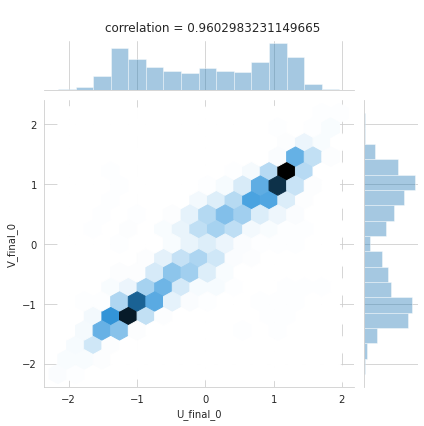

In [241]:
draw_correlations(Us, Vs, False, True, labels=['U_final', 'V_final'])

Find linear CCA result for wanted dim

In [242]:
from sklearn.cross_decomposition import CCA
cca = CCA(n_components=3)
X_train_c, Y_train_c = cca.fit_transform(X_train, Y_train)
X_c, Y_c = cca.transform(Xs, Ys)
print(f'X_c: mean {np.mean(X_c, axis=0)}, std {np.std(X_c, axis=0)}')
print(f'Y_c: mean {np.mean(Y_c, axis=0)}, std {np.std(Y_c, axis=0)}')

CCAtrain = draw_correlations(X_train_c, Y_train_c, False)
CCAtest = draw_correlations(X_c, Y_c, True)

X_c: mean [0.0110607  0.02042838 0.02286129], std [1.0588616  0.8315402  1.06791496]
Y_c: mean [-0.00058502  0.02966318  0.00706258], std [0.10326653 0.94324742 0.52553973]
correlations 0th entry: 0.0001521505585048211
correlations 1th entry: -0.020279262570677584
correlations 2th entry: 0.006713114860635614


In [243]:
for i in range(X_c.shape[-1]):  
  draw_correlations(Us, X_c[:,i][:, np.newaxis], True, False)
  draw_correlations(Vs, Y_c[:,i][:, np.newaxis], True, False)

correlations 0th entry: -0.1853968728989731
correlations 0th entry: -0.026426689207017497
correlations 0th entry: 0.6246691552914795
correlations 0th entry: 0.01917039646660057
correlations 0th entry: 0.05584945970949054
correlations 0th entry: 0.022013806667151414


correlations 0th entry: -0.007006197406655042
correlations 0th entry: 0.0019694041676724754
correlations 0th entry: 0.9232196575642339
correlations 0th entry: 0.8934505049205833
correlations 0th entry: -0.029479383194352678
correlations 0th entry: -0.02212685944639964


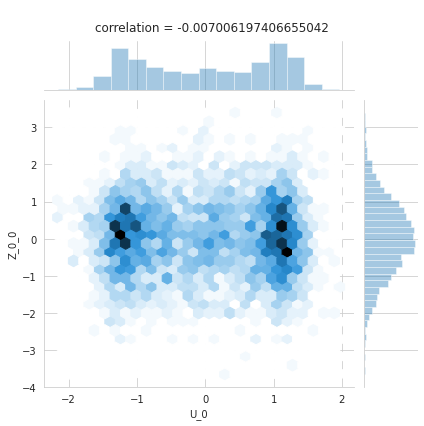

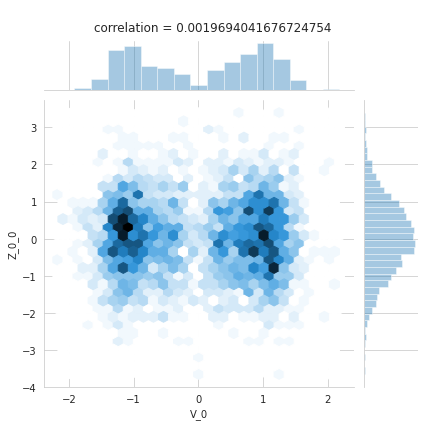

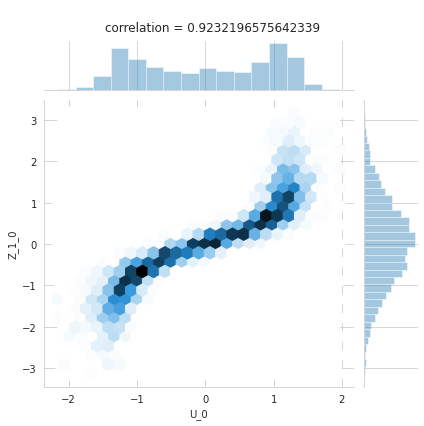

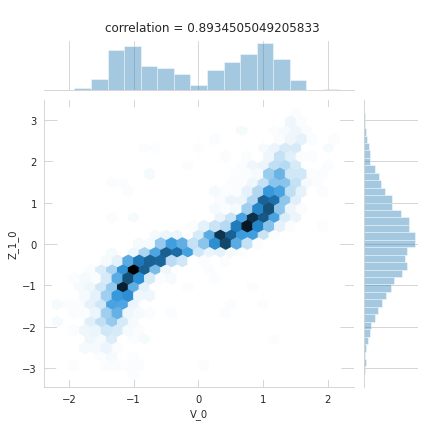

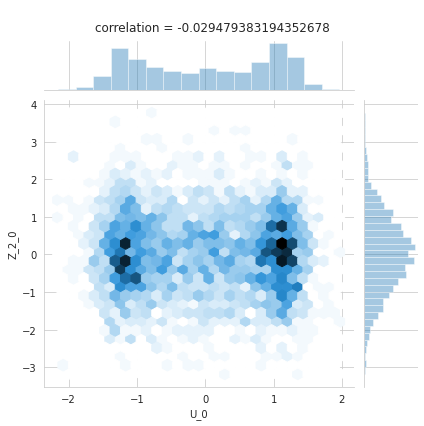

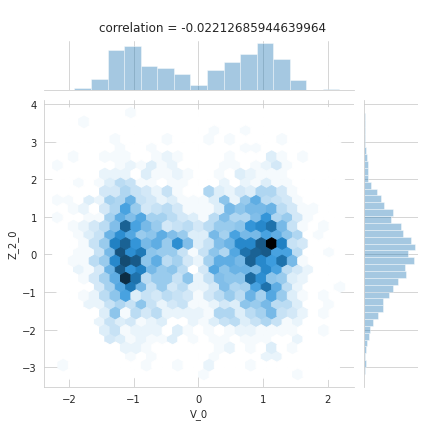

In [244]:
for i in range(X_c.shape[-1]):  
  draw_correlations(Us, Z_test[:,i][:, np.newaxis], True, True, labels=['U', f'Z_{i}'])
  draw_correlations(Vs, Z_test[:,i][:, np.newaxis], True, True, labels=['V', f'Z_{i}'])

In [245]:
# scores['LinearCCA training'] = [max(CCAtrain)] * len(scores['epoch'])
scores['LinearCCA validation'] = [max(CCAtest)] * len(scores['epoch'])
scores['Maximum score'] = [max(draw_correlations(X_prior, Y_prior))] * len(scores['epoch'])
scores['Maximum Linear score'] = [max(draw_correlations(X_non_linear, Y_non_linear))] * len(scores['epoch'])

correlations 0th entry: 0.7996572594718444
correlations 1th entry: 0.9899865237311534
correlations 2th entry: 0.4135256020560803
correlations 0th entry: 0.008333121519602518
correlations 1th entry: -0.0018116902912362778
correlations 2th entry: -0.0005352918606736386


In [246]:
# len(scores['epoch'])

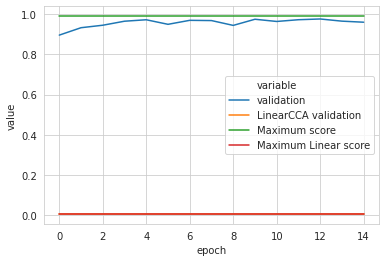

In [247]:
scores_data = pd.DataFrame(scores)
df_scores = pd.melt(scores_data, 'epoch')
g = sns.lineplot('epoch', 'value', 'variable', data=df_scores)


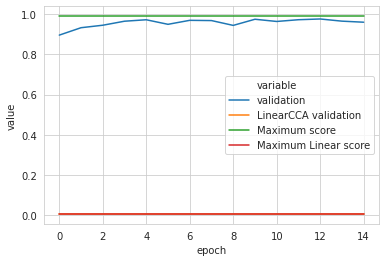

In [248]:
df_scores = pd.melt(scores_data[scores_data.epoch != -1], 'epoch')
g = sns.lineplot('epoch', 'value', 'variable', data=df_scores)

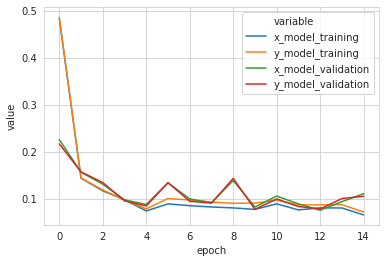

In [249]:
losses_data = pd.DataFrame(losses)
df_losses = pd.melt(losses_data, 'epoch')
sns.lineplot('epoch', 'value', 'variable', data=df_losses)